In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import warnings

warnings.filterwarnings("ignore")

In [2]:
pedpy_blue = (89 / 255, 178 / 255, 216 / 255)
pedpy_orange = (220 / 255, 160 / 255, 73 / 255)
pedpy_green = (108 / 255, 190 / 255, 167 / 255)
pedpy_petrol = (98 / 255, 190 / 255, 190 / 255)

# User Guide

This user guide will showcase the capabilities of *PedPy*. 
By following this guide you will learn how to set up your analysis and compute different metrics from the movement data.


This is a bottleneck experiment conducted at the University of Wuppertal in 2018.
You can see the basic setup of the experiment in the picture below:

```{eval-rst}
.. figure:: demo-data/bottleneck/040_c_56_h-.png
    :width: 400px
    :align: center
```

The data for this experiment is available {download}`here <demo-data/bottleneck/040_c_56_h-.txt>`, which belongs to this [experimental series](https://doi.org/10.34735/ped.2018.1) and is part of the publication [\"Crowds in front of bottlenecks at entrances from the perspective of physics and social psychology\"](https://doi.org/10.1098/rsif.2019.0871).

## Analysis set up

### Walkable area

In the beginning we will define the walkable area in which the pedestrian can move. 
For the used bottleneck experiment was conducted in the following set up:


```{eval-rst}
.. figure:: demo-data/bottleneck/experimental_setup.png
    :width: 400px
    :align: center
```

The run handled in this user guide had a bottleneck width of 0.5m and w=5.6m.

Below is the code for creating such a walkable area:

In [3]:
from pedpy import WalkableArea

walkable_area = WalkableArea(
    # complete area
    [
        (3.5, -2),
        (3.5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ],
    obstacles=[
        # left barrier
        [
            (-2.8, 7.0),
            (-2.8, 0.0),
            (-0.25, 0.0),
            (-0.25, -1.0),
            (-0.45, -1.0),
            (-0.45, -0.2),
            (-3.0, -0.2),
            (-3.0, 7.0),
            (-2.8, 7.0),
        ],
        # right barrier
        [
            (0.25, -1.0),
            (0.25, 0.0),
            (2.8, 0.0),
            (2.8, 7.0),
            (3.0, 7.0),
            (3.0, -0.2),
            (0.45, -0.2),
            (0.45, -1.0),
            (0.25, -1.0),
        ],
    ],
)

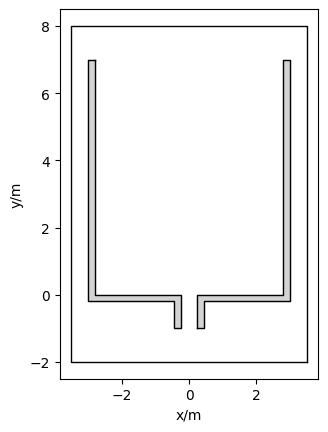

In [4]:
from pedpy import plot_walkable_area

plot_walkable_area(
    walkable_area=walkable_area, hole_color="lightgrey"
).set_aspect("equal")

### Prepare measurement details

After we defined where the pedestrians can move, we now need to define in which regions we want to analyze in more details. 
This regions can either be a specific line, an area, or the whole walkable area.

In case of this bottleneck the most interesting area is a little bit in front of the bottlenck (here 0.5m) and the line at the beginning of the bottleneck.
The area is slightly in front of the bottleneck as here the highest density occur. 
In *PedPy* such areas are called **MeasurementAreas** and the lines **MeasurementLines**.
Below you can see how to define these:

In [5]:
from pedpy import MeasurementArea, MeasurementLine

measurement_area = MeasurementArea(
    [(-0.4, 0.5), (0.4, 0.5), (0.4, 1.3), (-0.4, 1.3)]
)

measurement_line = MeasurementLine([(0.25, 0), (-0.25, 0)])

The corresponding measurement setup looks like:

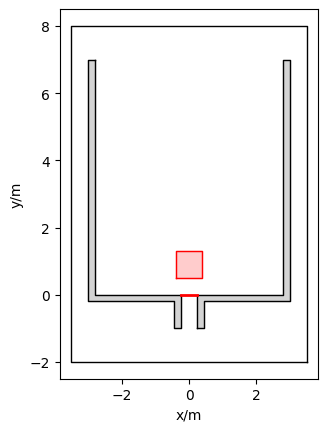

In [6]:
from pedpy import plot_measurement_setup

ax = plot_measurement_setup(
    walkable_area=walkable_area,
    hole_color="lightgrey",
    measurement_lines=[measurement_line],
    ml_color="r",
    ml_width=2,
    measurement_areas=[measurement_area],
    ma_color="r",
    ma_line_color="r",
    ma_line_width=1,
    ma_alpha=0.2,
).set_aspect("equal")

### Importing pedestrian movement data

The pedestrian movement data in *PedPy* is called trajectory data.

*PedPy* works with {class}`trajectory data <pedpy.data.trajectory_data.TrajectoryData>` which can be created from an import function for specific data files alternatively from a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with the following columns:

- "ID": unique numeric identifier for each person
- "frame": index of video frame where the positions were extracted
- "X", "Y": position of the person (in meter) 



#### Loading from Pandas DataFrame

To construct the  {class}`trajectory data <pedpy.data.trajectory_data.TrajectoryData>` from a **DataFrame** you also need to provide the frame rate at which the data was recorded.
If you have both the construction of the {class}`trajectory data <pedpy.data.trajectory_data.TrajectoryData>` can be done with:


In [7]:
from pedpy import TrajectoryData

data = pd.DataFrame(
    [[0, 1, 0, 0]],
    columns=["ID", "frame", "X", "Y"],
)
trajectory_data = TrajectoryData(data=data, frame_rate=25.0)

#### Loading from trajectory files

*Pedpy* can load trajectories directly from text files, when:

- values are separated by any whitespace, e.g., space, tab
- file has at least 5 columns in the following order: "ID", "frame", "X", "Y", "Z"
- file may contain comment lines with `#` at in the beginning

For meaningful analysis (and loading of the trajectory file) you also need
- unit of the trajectory (m or cm)
- frame rate

For recent experiments they are encoded in the header of the file, for older you may need to lead the documentation and provide the information in the loading process!

**Examples:**
With frame rate, but no unit
```
# description: UNI_CORR_500_01
# framerate: 25.00
#geometry: geometry.xml

# PersID	Frame	X	Y	Z
1	98	4.6012	1.8909	1.7600
1	99	4.5359	1.8976	1.7600
1	100	4.4470	1.9304	1.7600
...
```

No header at all:
```
1 27 164.834 780.844 168.937
1 28 164.835 771.893 168.937
1 29 163.736 762.665 168.937
1 30 161.967 753.088 168.937
...
```

*PedPy* provides an import function to load trajectory data provided in the [Juelich Data Archive](https://ped.fz-juelich.de/da/doku.php).
Since the data we want to analyze is from there, we can directly load the trajectory data with *PedPy*:  

In [8]:
from pedpy import load_trajectory, TrajectoryUnit

traj = load_trajectory(
    trajectory_file=pathlib.Path("demo-data/bottleneck/040_c_56_h-.txt"),
    default_unit=TrajectoryUnit.METER,  # needs to be provided as it not defined in the file
    # default_frame_rate=25., # can be ignored here as the frame rate is defined in the file
)

The loaded trajectory data look like:

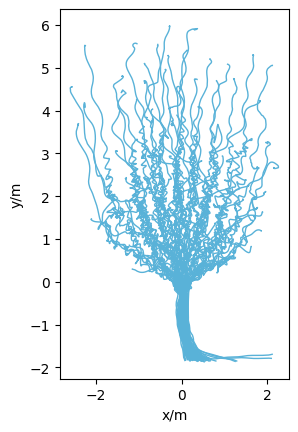

In [9]:
from pedpy import plot_trajectories

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
plot_trajectories(traj=traj, traj_color=pedpy_blue)
plt.show()

### Plot setup

For a better overview of our created measurement setup, see the plot below:

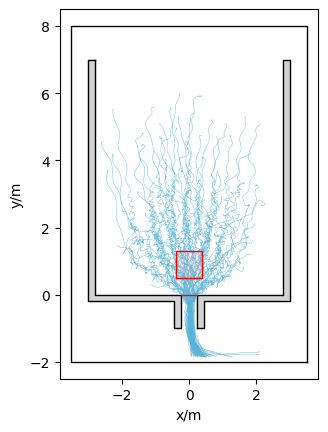

In [10]:
from pedpy import plot_measurement_setup, plot_walkable_area

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=traj,
    walkable_area=walkable_area,
    measurement_areas=[measurement_area],
    measurement_lines=[
        measurement_line,
    ],
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ml_color="r",
    ml_width=1,
    ma_color="r",
    ma_alpha=0.1,
    ma_line_color="r",
    ma_line_width=1,
    ax=ax,
)
plt.show()

### Validate that trajectory is completely inside the walkable area.

An important step before starting the analysis is to verify that all trajectories lie within the constructed walkable area.
Otherwise you might get errors.
*PedPy* provides a function to **test your trajectories**, and offers also a function to get **all invalid trajectories**:

In [11]:
from pedpy import is_trajectory_valid, get_invalid_trajectory

print(
    f"Trajectory is valid: {is_trajectory_valid(traj_data=traj, walkable_area=walkable_area)}"
)
get_invalid_trajectory(traj_data=traj, walkable_area=walkable_area)

Trajectory is valid: True


,ID,frame,X,Y,Z,points


**For demonstration purposes, wrongly place the obstacle s.th. some pedestrian walk through it!**

We now create a faulty geometry, s.th. you can see how the result would like.
Therefore, the right obstacle will be moved a bit towards the center of the bottlneck:

In [12]:
from pedpy import WalkableArea

walkable_area_faulty = WalkableArea(
    # complete area
    [
        (3.5, -2),
        (3.5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ],
    obstacles=[
        # left barrier
        [
            (-2.8, 7.0),
            (-2.8, 0.0),
            (-0.25, 0.0),
            (-0.25, -1.0),
            (-0.45, -1.0),
            (-0.45, -0.2),
            (-3.0, -0.2),
            (-3.0, 7.0),
            (-2.8, 7.0),
        ],
        # right barrier is too close to the middle
        [
            (0.15, -1.0),
            (0.15, 0.0),
            (2.8, 0.0),
            (2.8, 7.0),
            (3.0, 7.0),
            (3.0, -0.2),
            (0.45, -0.2),
            (0.45, -1.0),
            (0.25, -1.0),
        ],
    ],
)

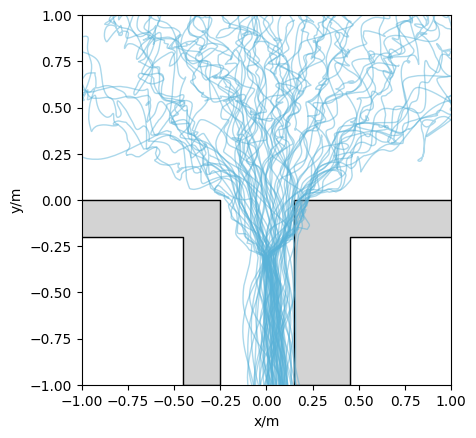

In [13]:
from pedpy import plot_measurement_setup, plot_walkable_area

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

ax = plot_measurement_setup(
    traj=traj,
    walkable_area=walkable_area_faulty,
    traj_color=pedpy_blue,
    traj_alpha=0.5,
    traj_width=1,
    hole_color="lightgrey",
    ax=ax,
)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
plt.show()

If you get any invalid trajectories, you should check whether you constructed your walkable area correctly.
In some cases you will get such errors when you have head trajectories, and the pedestrian lean over the obstacles.
Then you need to prepare your data before you can start your analysis.

In [14]:
from pedpy import is_trajectory_valid, get_invalid_trajectory

print(
    f"Trajectory is valid: {is_trajectory_valid(traj_data=traj, walkable_area=walkable_area_faulty)}"
)
get_invalid_trajectory(traj_data=traj, walkable_area=walkable_area_faulty)

Trajectory is valid: False


,ID,frame,X,Y,Z,points
922,1,922,0.2057,-0.0081,1.76,POINT (0.2057 -0.0081)
923,1,923,0.2041,-0.0190,1.76,POINT (0.2041 -0.019)
924,1,924,0.1919,-0.0312,1.76,POINT (0.1919 -0.0312)
925,1,925,0.1803,-0.0447,1.76,POINT (0.1803 -0.0447)
926,1,926,0.1677,-0.0594,1.76,POINT (0.1677 -0.0594)
...,...,...,...,...,...,...
58451,70,965,0.1939,-0.0029,1.76,POINT (0.1939 -0.0029)
58452,70,966,0.1872,-0.0146,1.76,POINT (0.1872 -0.0146)
58453,70,967,0.1791,-0.0274,1.76,POINT (0.1791 -0.0274)
58454,70,968,0.1691,-0.0411,1.76,POINT (0.1691 -0.0411)


## Analysis

Now that we set up the analysis environment, we can start with the real analysis.
*PedPy* provides different methods to obtain multiple metric from the trajectory data.
These methods will be shown in this section.

### Density

One of the fundamentatl metric in pedestrian dynamics is the density/
It describes how much space is available for a pedestrian.

#### Classic density

The classic approach to calculate the density is to count the number of pedestrians inside a specific space and divide it by the area of that space.
In *PedPy* this can be computed with:


In [15]:
from pedpy import compute_classic_density

classic_density = compute_classic_density(
    traj_data=traj, measurement_area=measurement_area
)

The resulting time-series can be seen below:

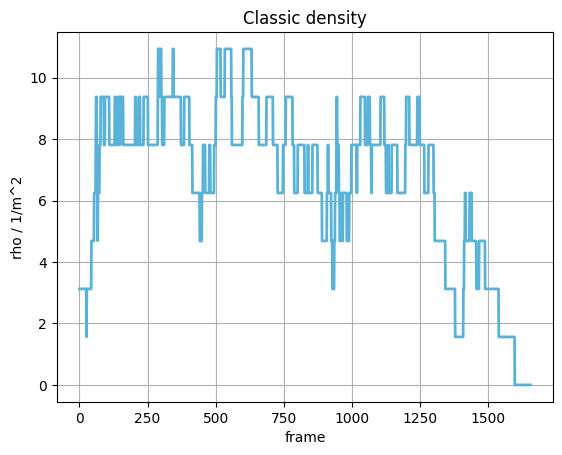

In [16]:
fig = plt.figure()
plt.title("Classic density")
plt.plot(
    classic_density.index,
    classic_density["classic density"].values,
    lw=2,
    linestyle="-",
    color=pedpy_blue,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.grid()
plt.show()

#### Voronoi density

Another approach for calculating the density is to compute the **Voronoi tesselation** of the pedestrians positions at a given time, the resulting Voronoi polygons directly relate to the individual's density.

##### Compute individual Voronoi Polygons

The first step for computing the Voronoi density, is to compute the individual's Voronoi polygon.
As these polygons may become infinite for pedestrians at the edge of the crowd, these polygons are restricted by the **walkable area**.
This cutting at the boundaries can lead to split Voronoi polygons. For each of the split polygons it is checked, in which the pedestrian is located. This polygon then is assigned.

:::{important}
As these Voronoi polygons work on the euclidean distance, some unexpected artifacts may occur on non-convex walkable areas. Please keep that in mind! How that may look like, you can see in the plots later in this guide.
:::

###### Without cut-off

The compuation of the individual polygons can be done from the **trajectory data** and **walkable area** with:

In [17]:
from pedpy import compute_individual_voronoi_polygons

individual = compute_individual_voronoi_polygons(
    traj_data=traj, walkable_area=walkable_area
)

###### With cut-off

When having a large **walkable area** or widely spread pedestrians the Voronoi polygons may become quite large.
In *PedPy* it is possible the restrict the size of the computed Polygons.
This can be done by defining a **cut off**, which is essentially an approximated circle which gives the maximum extension of a single Voronoi polygon.
For the creaton of the **cut off**, we need to define how accurate we want to approximate the circle, the differences can be seen below:

```{eval-rst}
.. figure:: images/voronoi_cutoff_differences.png
    :align: center
```

Now, with that **cut off** the compuation of the individual polygons becomes:

In [18]:
from pedpy import compute_individual_voronoi_polygons, Cutoff

individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj,
    walkable_area=walkable_area,
    cut_off=Cutoff(radius=1.0, quad_segments=3),
)

###### Comparison

To get an better impression what the differences between the Voronoi polygons with and without the **cut off** are, take a look at the plot below:

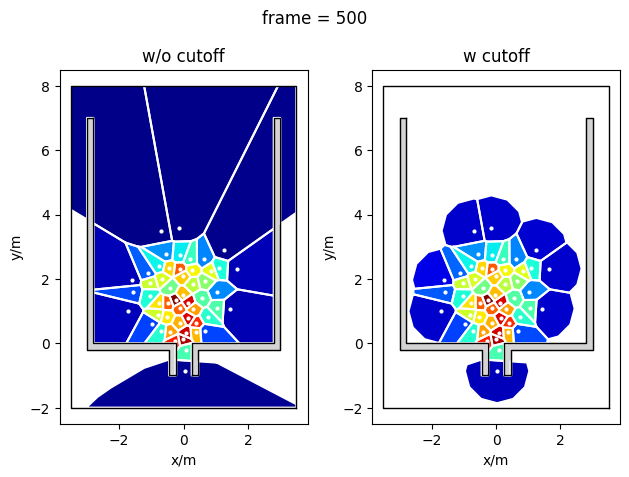

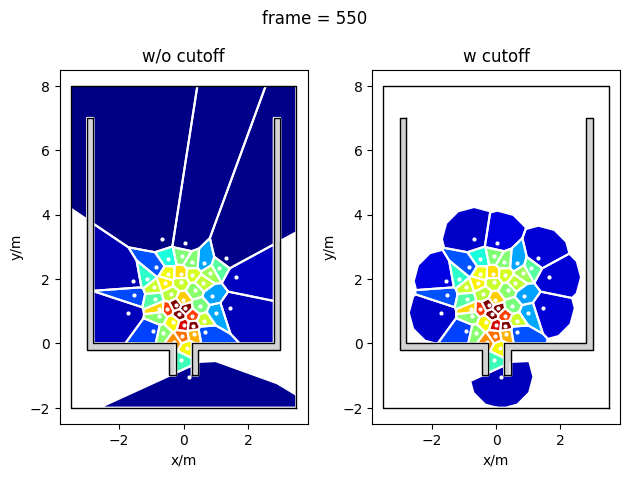

In [19]:
from pedpy import plot_voronoi_cells

frame_start = 500

for frame in range(frame_start, frame_start + 100, 50):
    fig = plt.figure(f"frame = {frame}")
    fig.suptitle(f"frame = {frame}")
    df_frame = individual[individual.frame == frame]
    df_frame = pd.merge(traj.data, df_frame, on=["ID", "frame"])

    ax1 = fig.add_subplot(121, aspect="equal")
    ax1.set_title("w/o cutoff")
    plot_voronoi_cells(
        data=df_frame,
        walkable_area=walkable_area,
        color_mode="density",
        show_ped_positions=True,
        ped_size=4,
        ax=ax1,
        show_colorbar=False,
        hole_color="lightgrey",
    )

    df_frame_cutoff = individual_cutoff[individual_cutoff.frame == frame]
    df_frame_cutoff = pd.merge(traj.data, df_frame_cutoff, on=["ID", "frame"])

    ax2 = fig.add_subplot(122, aspect="equal")
    ax2.set_title("w cutoff")

    plot_voronoi_cells(
        data=df_frame_cutoff,
        walkable_area=walkable_area,
        color_mode="density",
        show_ped_positions=True,
        ped_size=4,
        ax=ax2,
        show_colorbar=False,
        hole_color="lightgrey",
    )

    fig.tight_layout()
    plt.show()

##### Compute actual Voronoi density

From these individual data we can now compute the Voronoi density in the known measurement area.

###### Without cut-off

First, we compute the Voronoi density in the **measurement area** without a **cut-off**:

In [20]:
from pedpy import compute_voronoi_density

density_voronoi, intersecting = compute_voronoi_density(
    individual_voronoi_data=individual, measurement_area=measurement_area
)

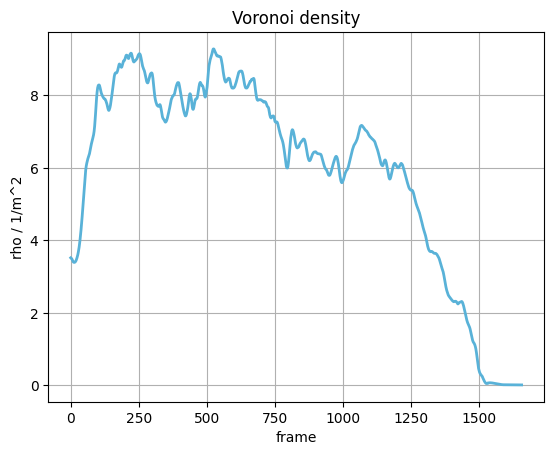

In [21]:
fig = plt.figure()
plt.title("Voronoi density")
plt.plot(
    density_voronoi.index,
    density_voronoi["voronoi density"].values,
    lw=2,
    linestyle="-",
    color=pedpy_blue,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.grid()
plt.show()

###### With cut-off

Second, we compute it now from the individual **cut-off** Voronoi polygons:


In [22]:
from pedpy import compute_voronoi_density

density_voronoi_cutoff, intersecting_cutoff = compute_voronoi_density(
    individual_voronoi_data=individual_cutoff, measurement_area=measurement_area
)

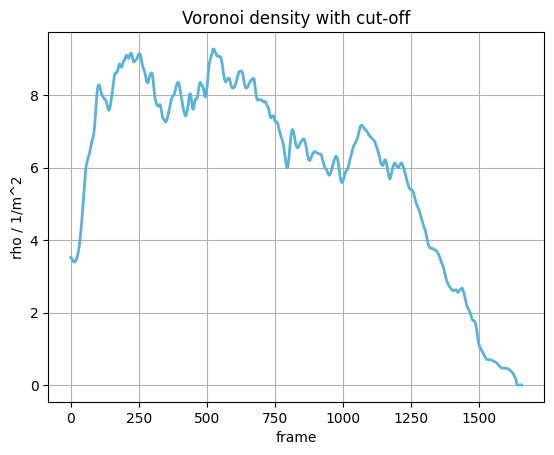

In [23]:
fig = plt.figure()
plt.title("Voronoi density with cut-off")
plt.plot(
    density_voronoi_cutoff.index,
    density_voronoi_cutoff["voronoi density"].values,
    lw=2,
    linestyle="-",
    color=pedpy_blue,
)
plt.xlabel("frame")
plt.ylabel("rho / 1/m^2")
plt.grid()
plt.show()

#### Comparison

Now we have obtained the mean density inside the measurement area with different methods.
To compare the results take a look at the following plot:

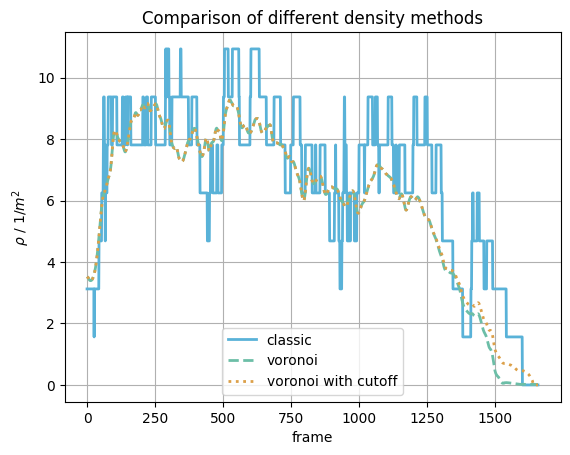

In [24]:
fig = plt.figure()
plt.title("Comparison of different density methods")
plt.plot(
    classic_density.reset_index().frame,
    classic_density["classic density"].values,
    label="classic",
    lw=2,
    linestyle="-",
    color=pedpy_blue,
)
plt.plot(
    density_voronoi.reset_index().frame,
    density_voronoi["voronoi density"],
    label="voronoi",
    lw=2,
    linestyle="--",
    color=pedpy_green,
)
plt.plot(
    density_voronoi_cutoff.reset_index().frame,
    density_voronoi_cutoff["voronoi density"],
    label="voronoi with cutoff",
    lw=2,
    linestyle=":",
    color=pedpy_orange,
)
plt.xlabel("frame")
plt.ylabel("$\\rho$ / 1/$m^2$")
plt.grid()
plt.legend()
plt.show()

#### Passing density (individual)

An other option to compute the individual density, is the **passing density**. 
For the computation it needs a **measurement line** and the distance to a second "virtual" **measurement line** which form a "virtual" **measurement area**.
For each pedestrian the frame range, in which they are inside this area is computed and counted how many pedestrian are inside the area for each frame. 
The average number of pedestrians in that frame range, then is the passing density.

Here, we want to compute the passing density inside the walkable area, this can be done with:

In [25]:
from pedpy import compute_passing_density
from pedpy import compute_frame_range_in_area

frames_in_area, used_area = compute_frame_range_in_area(
    traj_data=traj, measurement_line=measurement_line, width=1.0
)
passing_density = compute_passing_density(
    density_per_frame=classic_density, frames=frames_in_area
)

The plot below show the "virtual" **measurement area** which is used in the computation:

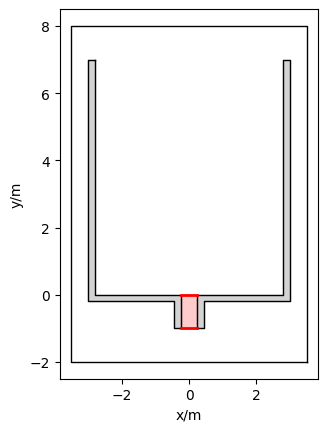

In [26]:
plt.figure()
ax = plot_measurement_setup(
    measurement_areas=[used_area],
    measurement_lines=[
        measurement_line,
        MeasurementLine(shapely.offset_curve(measurement_line.line, 1.0)),
    ],
    ml_color="r",
    ml_width=2,
    ma_color="r",
    ma_line_color="r",
    ma_line_width=0,
    ma_alpha=0.2,
    walkable_area=walkable_area,
    hole_color="lightgrey",
)
ax.set_aspect("equal")
plt.show()

This gives for each pedestrian one value for the density. 
The following plot shows how the individual density inside the bottleneck:

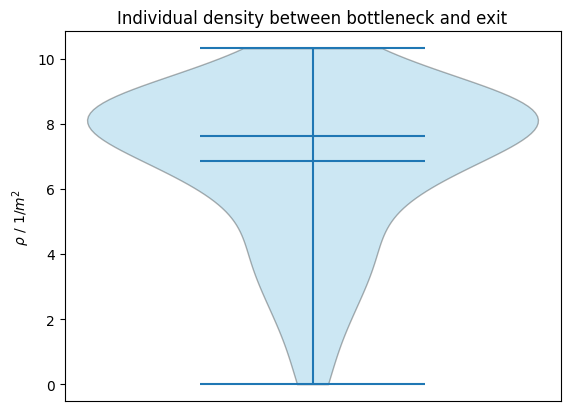

In [166]:
plt.figure()
plt.title("Individual density inside bottleneck")
violin_parts = plt.violinplot(passing_density.density, showmeans=True, showextrema=True, showmedians=True)
for pc in violin_parts['bodies']:
    pc.set_facecolor(pedpy_blue)
    pc.set_edgecolor('k')
plt.xlabel("")
plt.ylabel("$\\rho$ / 1/$m^2$")
plt.xticks([])
plt.show()

### Speed



#### Individual speed

In [28]:
from pedpy import compute_individual_velocity

individual_speed = compute_individual_velocity(
    traj_data=traj,
    frame_step=5,
    x_y_components=True,
)

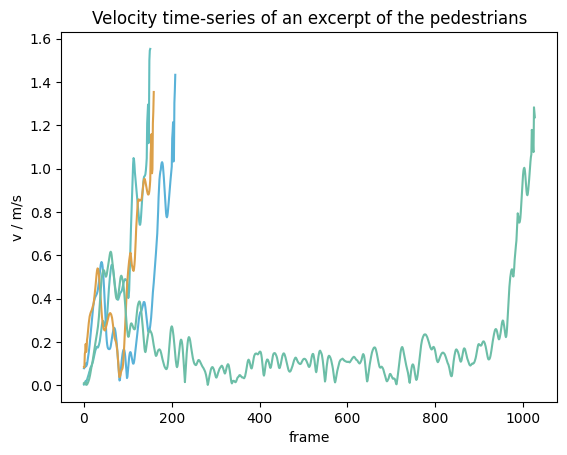

In [29]:
colors = [pedpy_blue, pedpy_petrol, pedpy_orange, pedpy_green]
ped_ids = [i for i in range(10, len(traj.data.ID.unique() - 1), 20)]

plt.figure()
plt.title("Velocity time-series of an excerpt of the pedestrians")
for color, ped_id in zip(colors, ped_ids):
    single_individual_speed = individual_speed[individual_speed.ID == ped_id]
    plt.plot(
        single_individual_speed.frame,
        single_individual_speed.speed,
        color=color,
    )

plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

In [30]:
individual_speed_direction = compute_individual_velocity(
    traj_data=traj,
    frame_step=5,
    movement_direction=np.array([0, -1]),
    x_y_components=True,
)

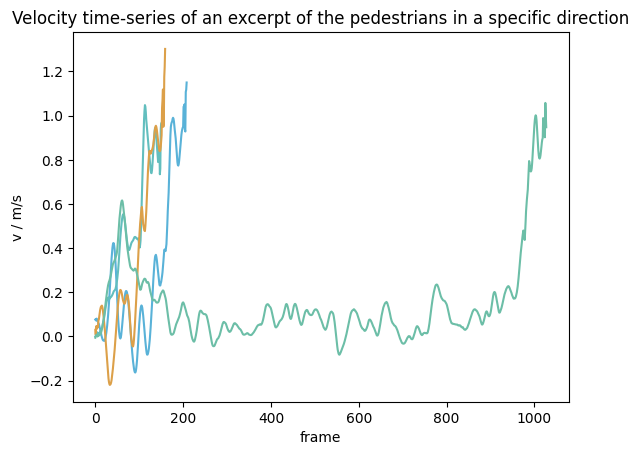

In [31]:
fig = plt.figure()
plt.title(
    "Velocity time-series of an excerpt of the pedestrians in a specific direction"
)
for color, ped_id in zip(colors, ped_ids):
    single_individual_speed = individual_speed_direction[
        individual_speed_direction.ID == ped_id
    ]
    plt.plot(
        single_individual_speed.frame,
        single_individual_speed.speed,
        color=color,
    )

plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

#### Mean speed (in measurement area)

In [32]:
from pedpy import compute_mean_velocity_per_frame

mean_speed = compute_mean_velocity_per_frame(
    traj_data=traj,
    measurement_area=measurement_area,
    individual_velocity=individual_speed,
)

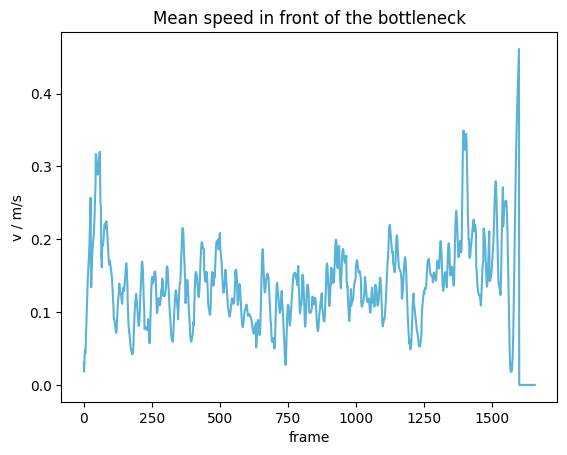

In [33]:
fig = plt.figure()
plt.title("Mean speed in front of the bottleneck")
plt.plot(mean_speed.index, mean_speed, color=pedpy_blue)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

In [34]:
mean_speed_direction = compute_mean_velocity_per_frame(
    traj_data=traj,
    measurement_area=measurement_area,
    individual_velocity=individual_speed_direction,
)

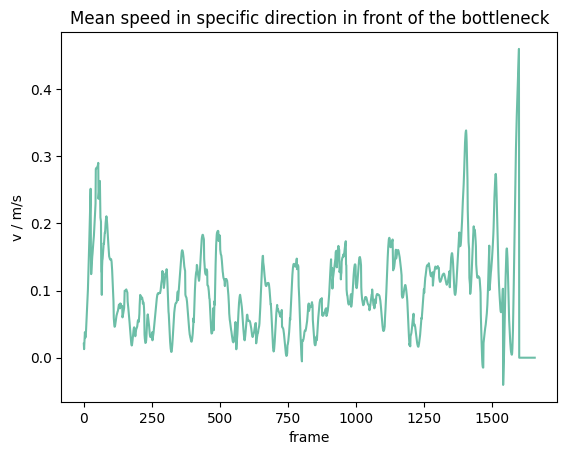

In [35]:
plt.figure()
plt.title("Mean speed in specific direction in front of the bottleneck")
plt.plot(mean_speed_direction.index, mean_speed_direction, color=pedpy_green)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

#### Voronoi speed

In [36]:
from pedpy import compute_voronoi_velocity

voronoi_speed = compute_voronoi_velocity(
    traj_data=traj,
    individual_voronoi_intersection=intersecting,
    individual_velocity=individual_speed,
    measurement_area=measurement_area,
)

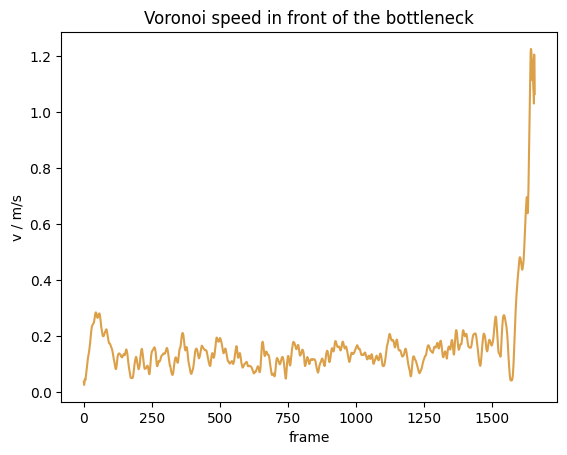

In [38]:
plt.figure()
plt.title("Voronoi speed in front of the bottleneck")
plt.plot(voronoi_speed.index, voronoi_speed, color=pedpy_orange)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

In [44]:
voronoi_speed_direction = compute_voronoi_velocity(
    traj_data=traj,
    individual_voronoi_intersection=intersecting,
    individual_velocity=individual_speed_direction,
    measurement_area=measurement_area,
)

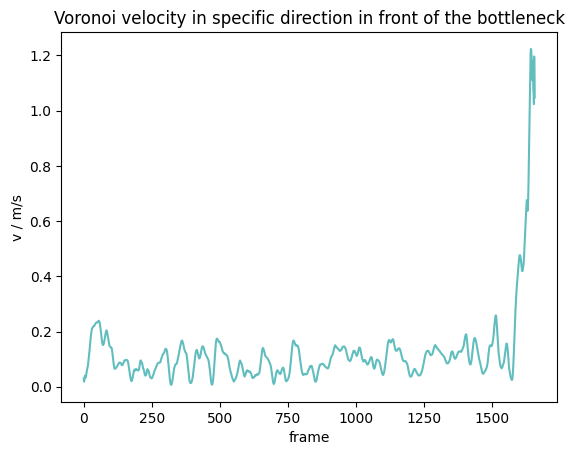

In [45]:
plt.figure()
plt.title("Voronoi velocity in specific direction in front of the bottleneck")
plt.plot(
    voronoi_speed_direction.index,
    voronoi_speed_direction,
    color=pedpy_petrol,
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.show()

#### Comparison mean velocity vs voronoi velocity

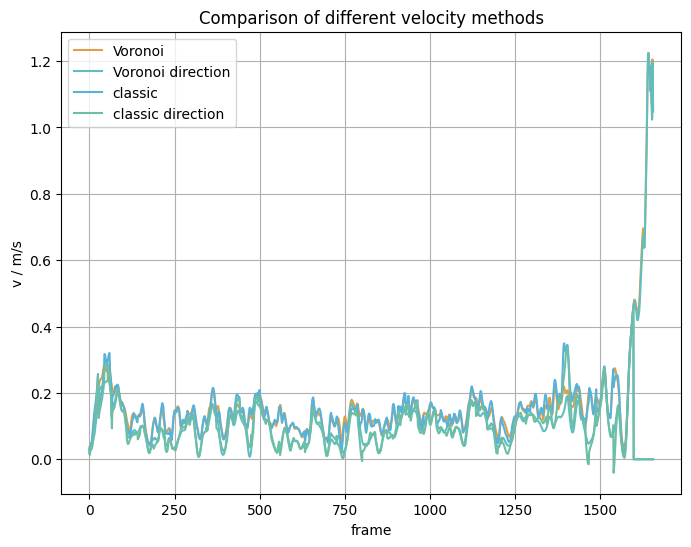

In [46]:
plt.figure(figsize=(8, 6))
plt.title("Comparison of different velocity methods")
plt.plot(
    voronoi_speed.reset_index().frame,
    voronoi_speed,
    label="Voronoi",
    color=pedpy_orange,
)
plt.plot(
    voronoi_speed_direction.reset_index().frame,
    voronoi_speed_direction,
    label="Voronoi direction",
    color=pedpy_petrol,
)
plt.plot(
    mean_speed.reset_index().frame,
    mean_speed,
    label="classic",
    color=pedpy_blue,
)
plt.plot(
    mean_speed_direction.reset_index().frame,
    mean_speed_direction,
    label="classic direction",
    color=pedpy_green,
)
plt.xlabel("frame")
plt.ylabel("v / m/s")
plt.legend()
plt.grid()
plt.show()

#### Passing speed (individual)

In [47]:
from pedpy import compute_passing_speed
from pedpy import compute_frame_range_in_area

passing_offset = 1.0
frames_in_area, _ = compute_frame_range_in_area(
    traj_data=traj, measurement_line=measurement_line, width=passing_offset
)
passing_speed = compute_passing_speed(
    frames_in_area=frames_in_area,
    frame_rate=traj.frame_rate,
    distance=passing_offset,
)

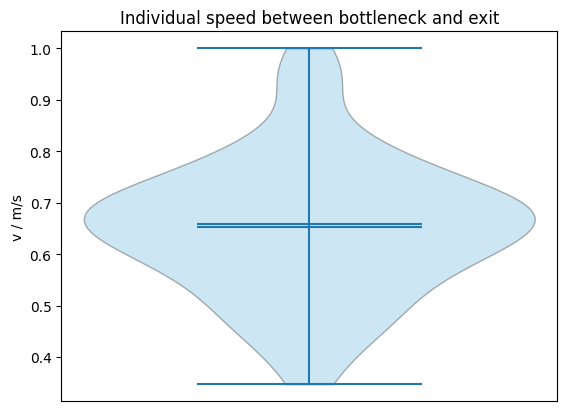

In [164]:
plt.figure()
plt.title("Individual speed between bottleneck and exit")
violin_parts = plt.violinplot(passing_speed.speed, showmeans=True, showextrema=True, showmedians=True)
for pc in violin_parts['bodies']:
    pc.set_facecolor(pedpy_blue)
    pc.set_edgecolor('k')
plt.xlabel("")
plt.ylabel("v / m/s")
plt.xticks([])
plt.show()

### Flow

#### N-t diagram

In [49]:
from pedpy import compute_n_t

nt, crossing = compute_n_t(
    traj_data=traj,
    measurement_line=measurement_line,
)

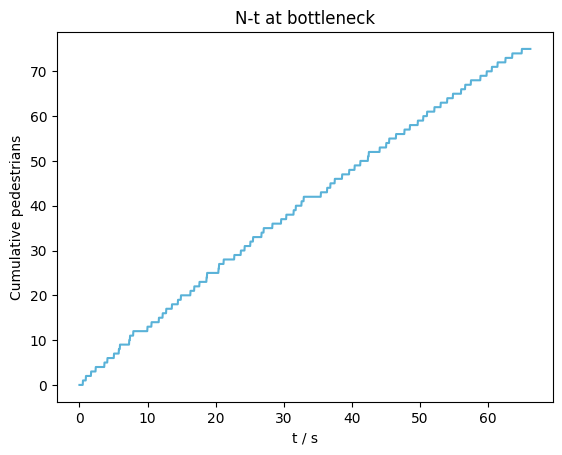

In [50]:
plt.figure()
plt.title("N-t at bottleneck")
plt.plot(nt["Time [s]"], nt["Cumulative pedestrians"], color=pedpy_blue)
plt.xlabel("t / s")
plt.ylabel("Cumulative pedestrians")
plt.show()

#### Flow

In [51]:
from pedpy import compute_flow

delta_t = 100
flow = compute_flow(
    nt=nt,
    crossing_frames=crossing,
    individual_speed=individual_speed,
    delta_t=delta_t,
    frame_rate=traj.frame_rate,
)

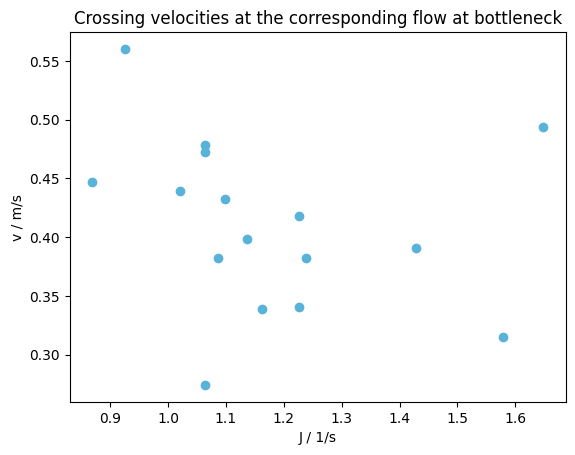

In [52]:
plt.figure()
plt.title("Crossing velocities at the corresponding flow at bottleneck")
plt.scatter(
    flow["Flow rate(1/s)"], flow["Mean velocity(m/s)"], color=pedpy_blue
)
plt.xlabel("J / 1/s")
plt.ylabel("v / m/s")
plt.show()

### Distance to entrance/Time to entrance


In [133]:
from pedpy import compute_time_distance_line

df_time_distance = compute_time_distance_line(traj_data=traj, measurement_line=measurement_line)

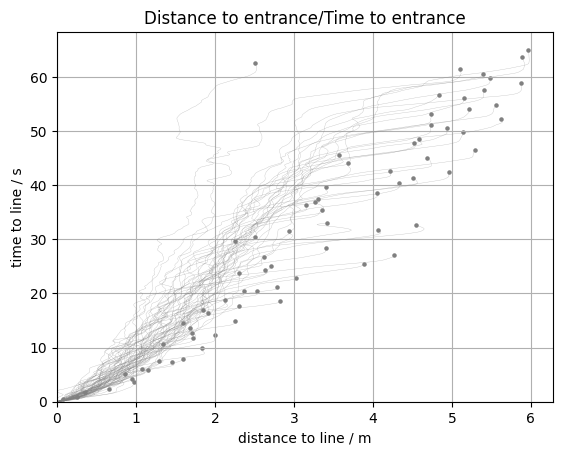

In [142]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Distance to entrance/Time to entrance")
for ped_id, ped_data in df_time_distance.groupby(by="ID"):
    plt.plot(ped_data.distance, ped_data.time/traj.frame_rate, c='gray', alpha=0.5, lw=0.25)
    min_data = ped_data[ped_data.frame == ped_data.frame.min()]
    plt.scatter(min_data.distance, min_data.time/traj.frame_rate, c='gray', s=5, marker='o')

ax.grid()
ax.set_xlabel("distance to line / m")
ax.set_ylabel("time to line / s")

ax.set_xlim([0, None])
ax.set_ylim([0, None])
plt.show()

### Neighborhood

In [53]:
from pedpy import compute_neighbors

neighbors = compute_neighbors(individual_cutoff)

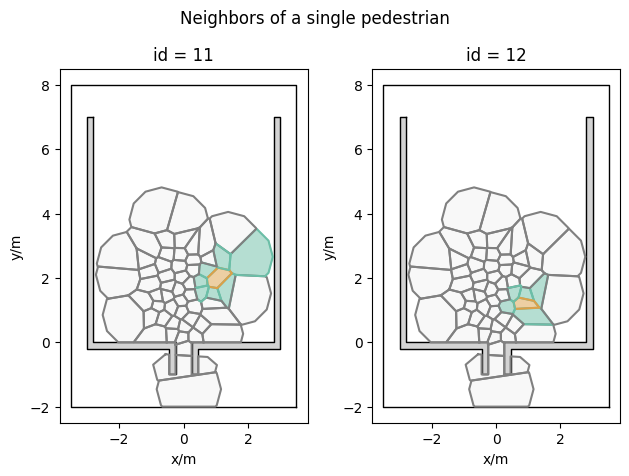

In [58]:
frame = 350

voronoi_neighbors = pd.merge(
    individual_cutoff[individual_cutoff.frame == frame],
    neighbors[neighbors.frame == frame],
    on=["ID", "frame"],
)
used_neighbors = voronoi_neighbors["ID"].values[8:10]


fig, axes = plt.subplots(nrows=1, ncols=len(used_neighbors))
fig.suptitle(f"Neighbors of a single pedestrian")

for base, ax in zip(used_neighbors, axes):
    base_neighbors = voronoi_neighbors[voronoi_neighbors["ID"] == base][
        "neighbors"
    ].values[0]
    ax.set_title(f"id = {base}")

    plot_walkable_area(ax=ax, walkable_area=walkable_area, hole_color="lightgrey")

    for _, row in voronoi_neighbors.iterrows():
        poly = row["individual voronoi"]
        ped_id = row["ID"]

        are_neighbors = ped_id in base_neighbors

        color = "gray"
        alpha = 0.05
        if ped_id == base:
            color = pedpy_orange
            alpha = 0.5

        if are_neighbors:
            color = pedpy_green
            alpha = 0.5

        ax.plot(*poly.exterior.xy, alpha=1, color=color)
        ax.fill(*poly.exterior.xy, alpha=alpha, color=color)
        ax.set_aspect("equal")
    fig.tight_layout()
plt.show()

### Profiles

In [59]:
from pedpy import (
    compute_profiles,
    compute_individual_voronoi_polygons,
    compute_individual_velocity,
    VelocityMethod,
)

individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj,
    walkable_area=walkable_area,
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

individual_speed = compute_individual_velocity(
    traj_data=traj,
    frame_step=5,
)

In [63]:
min_frame_profiles = 250 # We use here just an excerpt of the 
max_frame_profiles = 400 # trajectory data to reduce compute time

density_profiles, speed_profiles = compute_profiles(
    individual_voronoi_velocity_data=pd.merge(
        individual_cutoff[
            individual_cutoff.frame.between(
                min_frame_profiles, max_frame_profiles
            )
        ],
        individual_speed[
            individual_speed.frame.between(
                min_frame_profiles, max_frame_profiles
            )
        ],
        on=["ID", "frame"],
    ),
    walkable_area=walkable_area.polygon,
    grid_size=0.25,
    velocity_method=VelocityMethod.ARITHMETIC,
)

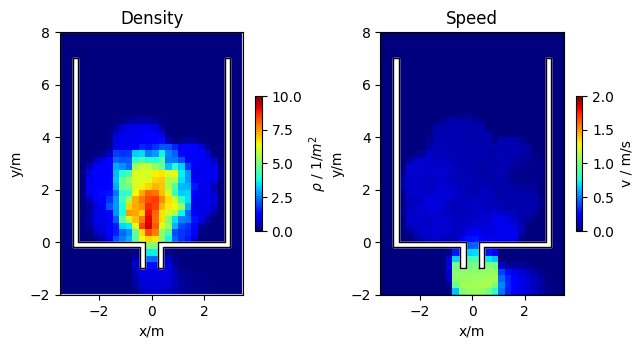

In [74]:
import matplotlib.pyplot as plt
import numpy as np

bounds = walkable_area.bounds

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)

ax0.set_title("Density")
cm = ax0.imshow(
    np.mean(density_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    interpolation="None",
    cmap="jet",
    vmin=0,
    vmax=10,
)
fig.colorbar(cm, ax=ax0, shrink=0.3, label="$\\rho$ / 1/$m^2$")
ax0.plot(*walkable_area.polygon.exterior.xy, color="w")
plot_walkable_area(walkable_area=walkable_area, ax=ax0, hole_color="w")

ax1.set_title("Speed")
cm = ax1.imshow(
    np.mean(speed_profiles, axis=0),
    extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
    cmap="jet",
    vmin=0,
    vmax=2,
)
fig.colorbar(cm, ax=ax1, shrink=0.3, label="v / m/s")
plot_walkable_area(walkable_area=walkable_area, ax=ax1, hole_color="w")


fig.tight_layout()

## Preprocess the data

Till now complete trajectories, but sometimes not all the data is relevant for the analysis...

### Geometric filtering

Links to pandas, shapely

#### Data inside Polygon

In [115]:
import shapely

bottleneck = shapely.Polygon([(0.25, 0), (0.25, -1), (-0.25, -1), (-0.25, 0)])
leaving_area = shapely.Polygon([(-3, -1), (-3, -2), (3, -2), (3, -1)])

In [90]:
data_inside_ma = traj.data[
    shapely.within(traj.data.points, bottleneck)
]

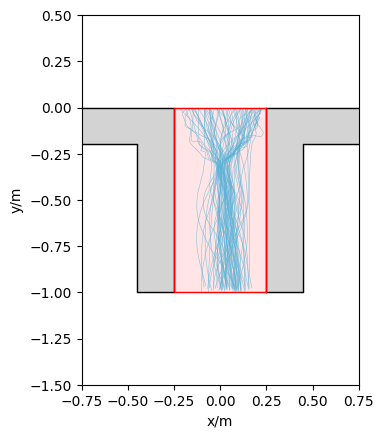

In [95]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=TrajectoryData(data_inside_ma, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    measurement_areas=[MeasurementArea(bottleneck)],
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ml_color="r",
    ml_width=1,
    ma_color="r",
    ma_alpha=0.1,
    ma_line_color="r",
    ma_line_width=1,
    ax=ax,
)
ax.set_xlim([-0.75, 0.75])
ax.set_ylim([-1.5, 0.5])
plt.show()

#### Data outside Polygon

In [120]:
data_outside_leaving_area = traj.data[
   ~shapely.within(traj.data.points, leaving_area)
]

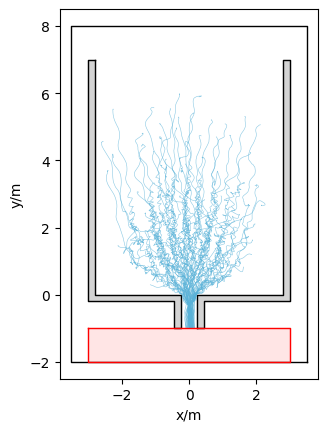

In [121]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

ax = plot_measurement_setup(
    traj=TrajectoryData(data_outside_leaving_area, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    measurement_areas=[MeasurementArea(leaving_area)],
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ml_color="r",
    ml_width=1,
    ma_color="r",
    ma_alpha=0.1,
    ma_line_color="r",
    ma_line_width=1,
    ax=ax,
)
plt.show()

#### Data close to Polygon

In [124]:
data_close_ma = traj.data[
    shapely.dwithin(traj.data.points, bottleneck, 1)
]

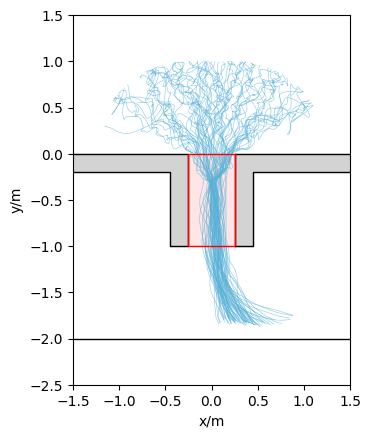

In [127]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=TrajectoryData(data_close_ma, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    measurement_areas=[MeasurementArea(bottleneck)],
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ml_color="r",
    ml_width=1,
    ma_color="r",
    ma_alpha=0.1,
    ma_line_color="r",
    ma_line_width=1,
    ax=ax,
)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-2.5, 1.5])
plt.show()

### Time based filtering

#### Get all data points in a frame range

In [131]:
data_frame_range = traj.data[
    traj.data.frame.between(300, 600, inclusive="both")
]

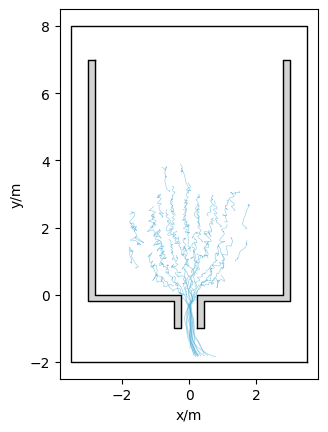

In [132]:
from pedpy import plot_measurement_setup

fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=TrajectoryData(data_frame_range, frame_rate=traj.frame_rate),
    walkable_area=walkable_area,
    traj_color=pedpy_blue,
    traj_alpha=0.7,
    traj_width=0.4,
    hole_color="lightgrey",
    ax=ax,
)
plt.show()

## What to do with the results?

Now we have completed our analysis, what can be done to 

- combine for further analysis
- save results

### Combine multiple DataFrames


In [ ]:
traj.data

In [ ]:
individual

In [ ]:
data_with_voronoi_cells = traj.data.merge(intersecting, on=["ID", "frame"])
data_with_voronoi_cells

In [ ]:
data_with_voronoi_cells_speed = data_with_voronoi_cells.merge(
    individual_speed[["ID", "frame", "speed"]], on=["ID", "frame"]
)
data_with_voronoi_cells_speed

### Save in files

#### Create directories to store the results

In [ ]:
pathlib.Path("results_introduction/profiles/velocity").mkdir(
    parents=True, exist_ok=True
)
pathlib.Path("results_introduction/profiles/density").mkdir(
    parents=True, exist_ok=True
)

results_directory = pathlib.Path("results_introduction")

#### Save Pandas DataFrame (result from everything but profiles) as csv

In [ ]:
import csv

data_with_voronoi_cells_speed["individual density"] = shapely.area(
    data_with_voronoi_cells_speed["individual voronoi"]
)

with open(
    results_directory / "individual_result.csv", "w"
) as individual_output_file:
    individual_output_file.write(f"#framerate:	{traj.frame_rate}\n\n")
    data_with_voronoi_cells_speed[
        [
            "ID",
            "frame",
            "X",
            "Y",
            "Z",
            "individual density",
            "speed",
            "individual voronoi",
            "intersection voronoi",
        ]
    ].to_csv(
        individual_output_file,
        mode="a",
        header=True,
        sep="\t",
        index_label=False,
        index=False,
        quoting=csv.QUOTE_NONNUMERIC,
    )

#### Save numpy arrays (result from profiles) as txt

In [ ]:
results_directory_density = results_directory / "profiles/density"
results_directory_velocity = results_directory / "profiles/velocity"

for i in range(len(range(min_frame_profiles, min_frame_profiles + 10))):
    frame = min_frame_profiles + i
    np.savetxt(
        results_directory_density / f"density_frame_{frame:05d}.txt",
        density_profiles[i],
    )
    np.savetxt(
        results_directory_velocity / f"velocity_frame_{frame:05d}.txt",
        speed_profiles[i],
    )